### Машинное Обучения

## Домашнее задание №2 - Дерево решений

**Общая информация**

**Срок сдачи:** 23 апреля 2024, 23:59   
**Штраф за опоздание:** -2 балла за каждые 2 дня опоздания

Решений залить в свой github репозиторий.

Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс MyDecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict . (Но название класса не менять)

In [662]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

In [876]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = {}
        self.criterion = criterion
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        # Ваш код здесь
        best_f = None
        best_thr = None
        best_error = float('inf')

        idx = np.argsort(x, axis=0)
        sorted_x = np.take_along_axis(x, idx, axis=0)
        sorted_y = np.take_along_axis(y.reshape(-1, 1), idx, axis=0)

        for j in range(x.shape[1]):  # Перебираем признаки
            y_sorted, x_sorted = sorted_y[:, j], sorted_x[:, j]
            # feature = x[:, j]  # Инициализируем рассматриваемый признак
            # idx = np.argsort(feature)  # Сортируем индексы по значению признака
            # y_sorted, x_sorted = y[idx], feature[idx]  # Сортируем записи по новому порядку индексов

            if len(np.unique(x_sorted)) <= 1:
                continue

            # Инициализируем возможные поклассовые количества объектов при разбиениях (правую и левую часть)
            left_cls_counts = np.array([np.cumsum(y_sorted == cls) for cls in np.unique(y)])
            left_count = np.arange(1, len(y) + 1)  # 1, 2, ..., N

            right_cls_counts = left_cls_counts[:, -1].reshape(-1, 1) - left_cls_counts
            right_count = left_count[-1] - left_count[:-1] # N - 1, N - 2, ..., 1

            # Убираем случаи, когда в левой или правой части нет элементов
            left_cls_counts,  right_cls_counts = left_cls_counts[:, :-1], right_cls_counts[:, :-1]
            left_count = left_count[:-1]

            if self.criterion == 'gini':
                # Берем суммы квадратов представителей классов в каждой части при разбиении
                left_squared_sums = np.sum(np.square(left_cls_counts), axis=0)
                right_squared_sums = np.sum(np.square(right_cls_counts), axis=0)
                errors = (left_count ** 2 - left_squared_sums) / left_count + (right_count ** 2 - right_squared_sums) / right_count

            elif self.criterion == 'entropy':
                # Расчёт вероятностей
                left_probs = left_cls_counts / left_count
                right_probs = right_cls_counts / right_count
                # Расчёт энтропии
                left_entropy = -np.sum(left_probs * np.log2(left_probs, where=left_probs > 0), axis=0)
                right_entropy = -np.sum(right_probs * np.log2(right_probs, where=right_probs > 0), axis=0)
                errors = left_count * left_entropy + right_count * right_entropy

            elif self.criterion == 'min_error':
                # Расчёт ошибки классификации
                left_classification_error = 1 - np.max(left_cls_counts / left_count, axis=0)
                right_classification_error = 1 - np.max(right_cls_counts / right_count, axis=0)
                errors = left_count * left_classification_error + right_count * right_classification_error

            # Индекс наименьшей ошибки, т.е. индекс значения признака, на этом значении надо делать сплит
            best_f_idx = np.argmin(errors)
            # Лучший thr для данной фичи
            best_f_thr = 0.5 * (x_sorted[best_f_idx] + x_sorted[best_f_idx + 1])
            # Минимальная ошибка для данной фичи при лучшем thr
            min_f_error = errors[best_f_idx]
            # Обновляем наименьшую ошибку, фичу и ее thr
            if min_f_error < best_error:
                best_error = min_f_error
                best_f = j
                best_thr = best_f_thr

        _, node_cls_counts = np.unique(y, return_counts=True)
        if self.criterion == 'gini':
            probs = node_cls_counts / len(y)
            node_info = 1 - np.sum(np.square(probs))
        elif self.criterion == 'entropy':
            probs = node_cls_counts / len(y)
            node_info = -np.sum(probs * np.log2(probs))
        elif self.criterion == 'min_error':
            probs = max(node_cls_counts) / len(y)
            node_info = 1 - probs

        if best_f in self.feature_importances_.keys():
            self.feature_importances_[best_f] += node_info - best_error / len(y)
        else:
            self.feature_importances_[best_f] = node_info - best_error / len(y)

        return best_f, best_thr



    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        # Ваш код здесь
        if depth >= self.max_depth or len(y) < self.min_samples_split or len(np.unique(y)) == 1:
            class_counts = np.bincount(y, minlength=self.num_class)
            most_common = np.argmax(class_counts)
            self.tree[node_id] = (self.LEAF_TYPE, most_common, class_counts[most_common] / len(y))
            return

        best_f, best_thr = self.__find_threshold(x, y)
        if best_f is None:
            # Если признак для разделения не найден, делаем узел листом
            class_counts = np.bincount(y, minlength=self.num_class)
            most_common = np.argmax(class_counts)
            self.tree[node_id] = (self.LEAF_TYPE, most_common, class_counts[most_common] / len(y))
            return

        x_left, x_right, y_left, y_right = self.__div_samples(x, y, best_f, best_thr)
        if len(y_left) == 0 or len(y_right) == 0:
            class_counts = np.bincount(y, minlength=self.num_class)
            most_common = np.argmax(class_counts)
            self.tree[node_id] = (self.LEAF_TYPE, most_common, class_counts[most_common] / len(y))
            return

        self.tree[node_id] = (self.NON_LEAF_TYPE, best_f, best_thr)
        self.__fit_node(x_left, y_left, 2 * node_id + 1, depth + 1)
        self.__fit_node(x_right, y_right, 2 * node_id + 2, depth + 1)

    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.num_class = np.unique(y).size
        self.__fit_node(x, y, 0, 0)

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]

    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])

    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)

    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        # Ваш код здесь
        return dict(sorted(self.feature_importances_.items(), key=lambda item: item[1], reverse=True))

In [789]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [790]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target, random_state=1337)

In [791]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [792]:
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.8888888888888888
0.8888888888888888


Совет: Проверьте, что ваша реализация корректно работает с признаками в которых встречаются повторы.
И подумайте, какие еще граничные случаи могут быть.
Например, проверьте, что на таком примере ваша модель корректно работает:

In [807]:
X = np.array([[1] * 10, [0, 1, 2, 5, 6, 3, 4, 7, 8, 9]]).T
y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
for depth in range(1, 5):
    my_clf = MyDecisionTreeClassifier(max_depth=depth)
    my_clf.fit(X, y)
    print("DEPTH:", depth, "\n\t\tTree:", my_clf.tree, my_clf.predict(X))

DEPTH: 1 
		Tree: {0: (0, 1, 2.5), 1: (1, 1, 0.7142857142857143), 2: (1, 0, 1.0)} [0 0 0 1 1 1 1 1 1 1]
DEPTH: 2 
		Tree: {0: (0, 1, 2.5), 1: (0, 1, 6.5), 3: (1, 1, 1.0), 4: (1, 0, 0.5), 2: (1, 0, 1.0)} [0 0 0 0 0 0 0 1 1 1]
DEPTH: 3 
		Tree: {0: (0, 1, 2.5), 1: (0, 1, 6.5), 3: (1, 1, 1.0), 4: (0, 1, 4.5), 9: (1, 0, 1.0), 10: (1, 1, 1.0), 2: (1, 0, 1.0)} [0 0 0 0 0 1 1 1 1 1]
DEPTH: 4 
		Tree: {0: (0, 1, 2.5), 1: (0, 1, 6.5), 3: (1, 1, 1.0), 4: (0, 1, 4.5), 9: (1, 0, 1.0), 10: (1, 1, 1.0), 2: (1, 0, 1.0)} [0 0 0 0 0 1 1 1 1 1]


## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine.
Для этого используем numpy.

In [801]:
%time clf.fit(X_train, y_train)

CPU times: user 3.26 ms, sys: 0 ns, total: 3.26 ms
Wall time: 3.18 ms


DecisionTreeClassifier()

In [802]:
%time my_clf.fit(X_train, y_train)

CPU times: user 16.8 ms, sys: 0 ns, total: 16.8 ms
Wall time: 18 ms


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match).

Данные и описания колонок во вложениях.

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Либо воспользоваться функцией:

In [808]:
def preprocess_spd_data(df):
    df = df.iloc[:, :97]

    to_drop = [
        'id', 'idg', 'condtn', 'round', 'position', 'positin1', 'order', 'partner',
        'age_o', 'race_o', 'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
        'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o', 'like_o', 'prob_o','met_o',
        'field', 'undergra', 'from', 'zipcode', 'income', 'career', 'sports', 'tvsports', 'exercise',
        'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies',
        'concerts', 'music', 'shopping', 'yoga', 'expnum',
        'mn_sat', 'tuition'
    ]

    df = df.drop(to_drop, axis=1)
    df = df.dropna(subset=['age', 'imprelig', 'imprace', 'date'])

    df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)
    df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(18)

    # attr1 processing
    df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1',
                                            'amb1_1', 'shar1_1']].sum(axis=1)
    df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] =\
    (df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].T /
     df.loc[:, 'temp_totalsum'].T).T * 100

    # attr2 processing
    df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1',
                                            'amb2_1', 'shar2_1']].sum(axis=1)
    df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] =\
    (df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].T /
     df.loc[:, 'temp_totalsum'].T).T * 100
    df = df.drop(['temp_totalsum'], axis=1)

    for i in [4, 5]:
        feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i),
                'intel{}_1'.format(i), 'fun{}_1'.format(i),
                'amb{}_1'.format(i), 'shar{}_1'.format(i)]

        if i != 4:
            feat.remove('shar{}_1'.format(i))

        df = df.drop(feat, axis=1)

    df = df.drop(['wave'], axis=1)
    df = df.dropna()
    return df

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. В качестве метрики можно взять roc-auc.


In [819]:
df = pd.read_csv('/content/sample_data/Speed_Dating_Data.csv', encoding='latin1')
df = preprocess_spd_data(df)
np.unique(df['match'], return_counts=True)

(array([0, 1]), array([6775, 1329]))

In [820]:
X = df.drop('match', axis=1).to_numpy()
y = df['match'].to_numpy()

In [821]:
from imblearn.over_sampling import SMOTE

overSampler = SMOTE(random_state=1337)
X, y = overSampler.fit_resample(X, y)

print(np.unique(y, return_counts=True))

# from imblearn.under_sampling import RandomUnderSampler

# rus = RandomUnderSampler(random_state=0)
# X_reduced, y_reduced = rus.fit_resample(X, y)

# print(X_reduced.shape, y_reduced.shape)

# np.unique(y_reduced, return_counts=True)

(array([0, 1]), array([6775, 6775]))


In [822]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)

In [823]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2, max_depth=5)
my_clf.fit(X_train, y_train)

clf = DecisionTreeClassifier(min_samples_split=2, max_depth=5)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [824]:
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.6947109471094711
0.6856088560885609


In [825]:
def get_proba_from_tree(x, tree, node_id=0, positive_class=1):
    node = tree[node_id]
    if node[0] == MyDecisionTreeClassifier.LEAF_TYPE:
        if node[1] == positive_class:
            return node[2]
        else:
            return 1 - node[2]
    feature_id, threshold = node[1], node[2]
    if x[feature_id] > threshold:
        return get_proba_from_tree(x, tree, 2 * node_id + 1, positive_class)
    else:
        return get_proba_from_tree(x, tree, 2 * node_id + 2, positive_class)

y_probas = np.array([get_proba_from_tree(xi, my_clf.tree) for xi in X_test])

In [826]:
roc_auc_score(y_score=y_probas, y_true=y_test)

0.7605952327927774

In [ ]:
np.unique(y_probas)

In [ ]:
y_probas_clf = clf.predict_proba(X_test)[:, 1]
np.unique(y_probas_clf)

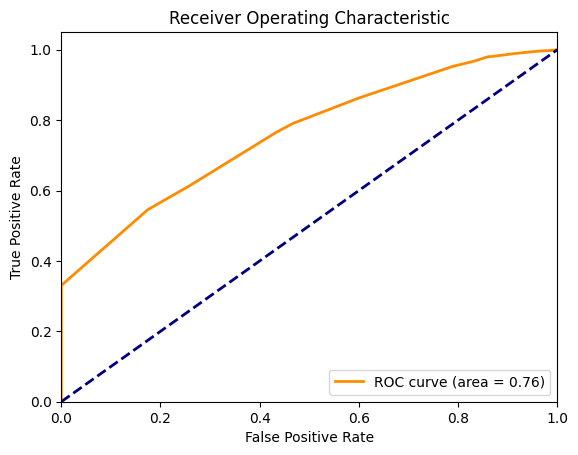

In [829]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_probas)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности.
Постройте графики зависимости точности на валидации и трейне от глубины дерева, от минимального числа объектов для сплита. (Т.е должно быть 2 графика, на каждой должны быть 2 кривые - для трейна и валидации)
Какой максимальной точности удалось достигнуть?

In [830]:
my_clf_G = MyDecisionTreeClassifier(min_samples_split=2, max_depth=5, criterion='gini')
my_clf_G.fit(X_train, y_train)
y_probas = np.array([get_proba_from_tree(xi, my_clf_G.tree) for xi in X_test])
print(f'roc_auc_score on Test: {roc_auc_score(y_score=y_probas, y_true=y_test)}, accuracy_score on Test: {accuracy_score(y_pred=my_clf_G.predict(X_test), y_true=y_test)}')

roc_auc_score on Test: 0.7605952327927774, accuracy_score on Test: 0.6856088560885609


In [831]:
my_clf_E = MyDecisionTreeClassifier(min_samples_split=2, max_depth=5, criterion='entropy')
my_clf_E.fit(X_train, y_train)
y_probas = np.array([get_proba_from_tree(xi, my_clf_E.tree) for xi in X_test])
print(f'roc_auc_score on Test: {roc_auc_score(y_score=y_probas, y_true=y_test)}, accuracy_score on Test: {accuracy_score(y_pred=my_clf_E.predict(X_test), y_true=y_test)}')

roc_auc_score on Test: 0.7570484399146367, accuracy_score on Test: 0.6853628536285363


In [832]:
my_clf_miner = MyDecisionTreeClassifier(min_samples_split=2, max_depth=5, criterion='min_error')
my_clf_miner.fit(X_train, y_train)
y_probas = np.array([get_proba_from_tree(xi, my_clf_miner.tree) for xi in X_test])
print(f'roc_auc_score on Test: {roc_auc_score(y_score=y_probas, y_true=y_test)}, accuracy_score on Test: {accuracy_score(y_pred=my_clf_miner.predict(X_test), y_true=y_test)}')

roc_auc_score on Test: 0.7351700146403243, accuracy_score on Test: 0.7025830258302583


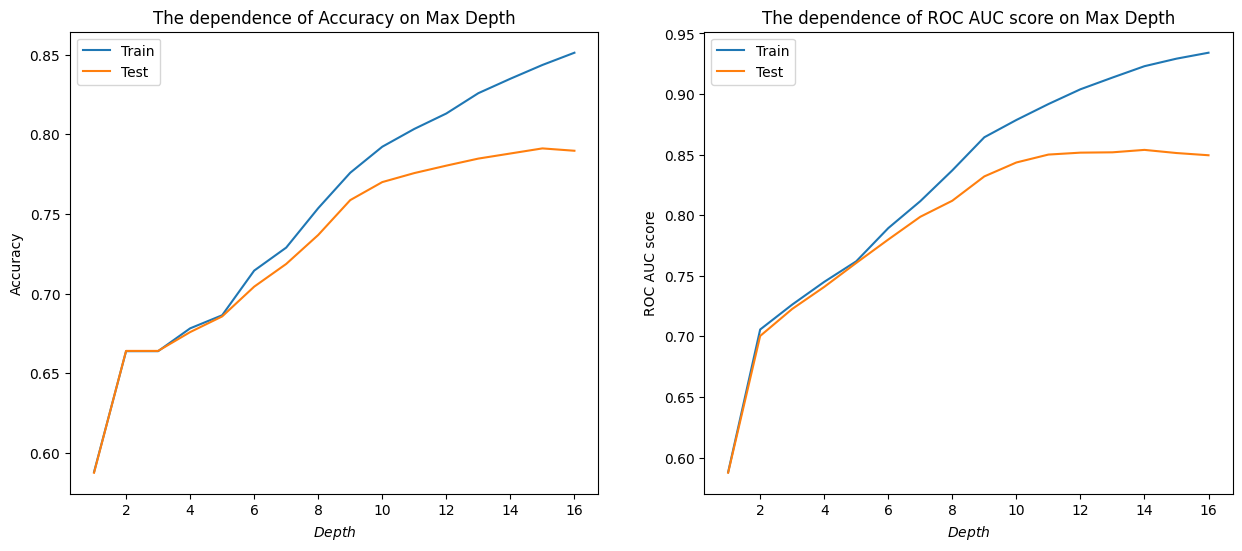

In [834]:
dephts_list = range(1, 17)

train_accuracy = []
test_accuracy = []

train_roc_auc = []
test_roc_auc = []

for depth in dephts_list:
    my_clf = MyDecisionTreeClassifier(min_samples_split=2, max_depth=depth, criterion='gini')
    my_clf.fit(X_train, y_train)

    y_train_probas = np.array([get_proba_from_tree(xi, my_clf.tree) for xi in X_train])
    y_test_probas = np.array([get_proba_from_tree(xi, my_clf.tree) for xi in X_test])

    train_accuracy.append(accuracy_score(y_pred=my_clf.predict(X_train), y_true=y_train))
    test_accuracy.append(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

    train_roc_auc.append(roc_auc_score(y_score=y_train_probas, y_true=y_train))
    test_roc_auc.append(roc_auc_score(y_score=y_test_probas, y_true=y_test))


plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.title("The dependence of Accuracy on Max Depth")
plt.xlabel(r"$Depth$")
plt.ylabel(r"Accuracy")
plt.plot(dephts_list, train_accuracy, label='Train')
plt.plot(dephts_list, test_accuracy, label='Test')
plt.legend()

plt.subplot(1, 2, 2)
plt.title("The dependence of ROC AUC score on Max Depth")
plt.xlabel(r"$Depth$")
plt.ylabel(r"ROC AUC score")
plt.plot(dephts_list, train_roc_auc, label='Train')
plt.plot(dephts_list, test_roc_auc, label='Test')
plt.legend()

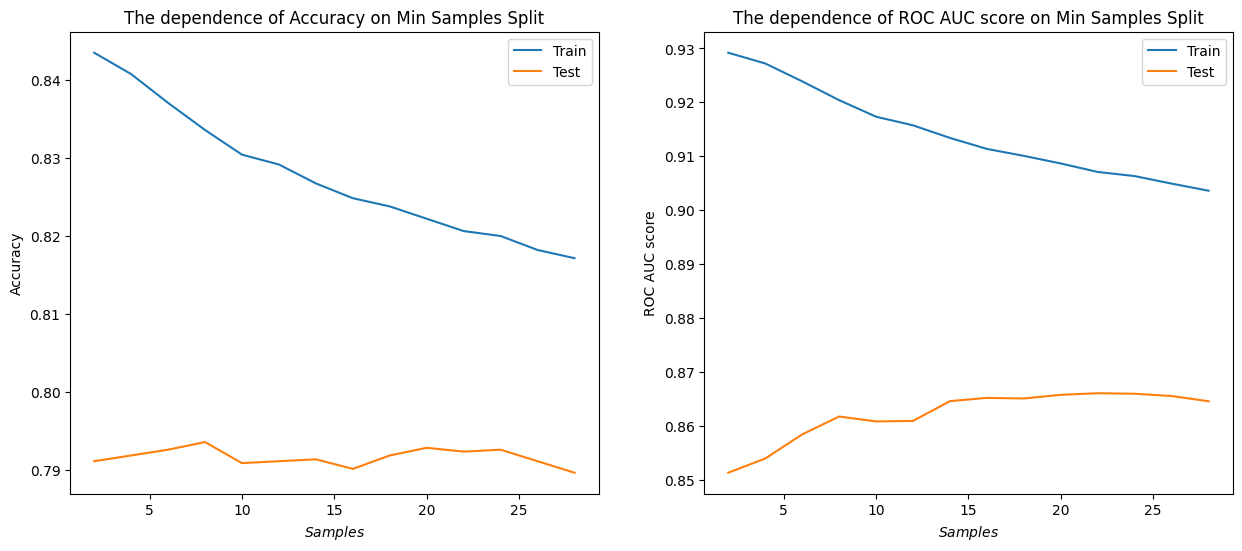

In [835]:
split_list = range(2, 30, 2)

train_accuracy = []
test_accuracy = []

train_roc_auc = []
test_roc_auc = []

for samples in split_list:
    my_clf = MyDecisionTreeClassifier(min_samples_split=samples, max_depth=15, criterion='gini')
    my_clf.fit(X_train, y_train)

    y_train_probas = np.array([get_proba_from_tree(xi, my_clf.tree) for xi in X_train])
    y_test_probas = np.array([get_proba_from_tree(xi, my_clf.tree) for xi in X_test])

    train_accuracy.append(accuracy_score(y_pred=my_clf.predict(X_train), y_true=y_train))
    test_accuracy.append(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

    train_roc_auc.append(roc_auc_score(y_score=y_train_probas, y_true=y_train))
    test_roc_auc.append(roc_auc_score(y_score=y_test_probas, y_true=y_test))


plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.title("The dependence of Accuracy on Min Samples Split")
plt.xlabel(r"$Samples$")
plt.ylabel(r"Accuracy")
plt.plot(split_list, train_accuracy, label='Train')
plt.plot(split_list, test_accuracy, label='Test')
plt.legend()

plt.subplot(1, 2, 2)
plt.title("The dependence of ROC AUC score on Min Samples Split")
plt.xlabel(r"$Samples$")
plt.ylabel(r"ROC AUC score")
plt.plot(split_list, train_roc_auc, label='Train')
plt.plot(split_list, test_roc_auc, label='Test')
plt.legend()

In [836]:
best_clf = MyDecisionTreeClassifier(min_samples_split=20, max_depth=15, criterion='gini')
best_clf.fit(X_train, y_train)
y_probas = np.array([get_proba_from_tree(xi, best_clf.tree) for xi in X_test])
print(f'roc_auc_score on Test: {roc_auc_score(y_score=y_probas, y_true=y_test)}, accuracy_score on Test: {accuracy_score(y_pred=best_clf.predict(X_test), y_true=y_test)}')

roc_auc_score on Test: 0.8657567217679935, accuracy_score on Test: 0.7928659286592866


__Ответ__: оптимальным критерием информативности оказался критерий Джини. Оптимальным параметром максимальной глубины оказалось значение 15, для минимального числа объектов для сплита - 20. При таких значения гиперпараметров: Accuracy = 0.79, roc-auc = 0.87.

Известным фактом является то, что деревья решений сильно переобучаются при увеличении глубины и просто запоминают трейн.
Замечаете ли вы такой эффект судя по графикам? Что при этом происходит с качеством на валидации?

__Ответ__: на графиках зависимости качества от максимальной глубины дерева видно, что при большой глубине (>20) качество на train части датасета растёт, а на test части (валидации) начинает падать. Это признак переобучения.

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве.

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший.
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева.

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [877]:
best_clf = MyDecisionTreeClassifier(min_samples_split=20, max_depth=15, criterion='gini')
best_clf.fit(X_train, y_train)

In [878]:
best_clf.get_feature_importance()

{3: 3.2374426967263608,
 2: 1.8165162620051656,
 11: 1.2126891841137915,
 5: 1.1203875583936822,
 0: 0.8940665368593192,
 18: 0.8613235933006145,
 19: 0.7889085428513802,
 6: 0.7811321636179209,
 27: 0.6952344444357464,
 9: 0.6926927532070144,
 7: 0.6684550656274629,
 15: 0.6426025952788621,
 13: 0.6243110300994239,
 21: 0.621507031524513,
 10: 0.5854127581473026,
 14: 0.5607545748909841,
 30: 0.5528027985544575,
 12: 0.5284437110274591,
 8: 0.4627160739171411,
 24: 0.4159366327352192,
 17: 0.39513514155689083,
 22: 0.39393084679309615,
 23: 0.3937797579631071,
 1: 0.3899836071898032,
 26: 0.2840363433270219,
 31: 0.2771600792389046,
 28: 0.270493555878072,
 16: 0.2662729309609523,
 25: 0.24722968389348207,
 20: 0.20471380667424297,
 4: 0.1875787018703748,
 29: 0.18680766529944676}

In [879]:
df.drop('match', axis=1).columns[list(best_clf.get_feature_importance().keys())][:10]

Index(['int_corr', 'pid', 'date', 'age', 'iid', 'fun1_1', 'amb1_1', 'field_cd',
       'attr3_1', 'imprelig'],
      dtype='object')

## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

